### Import 

In [17]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set()

---
### Load

In [4]:
# df_business = pd.read_json('./yelp_dataset/yelp_academic_dataset_business.json', lines=True)
# df_checkin = pd.read_json('./yelp_dataset/yelp_academic_dataset_checkin.json', lines=True)
# df_review = pd.read_json('./yelp_dataset/yelp_academic_dataset_review.json', lines=True)
# df_tip = pd.read_json('./yelp_dataset/yelp_academic_dataset_tip.json', lines=True)
# df_user = pd.read_json('./yelp_dataset/yelp_academic_dataset_user.json', lines=True)

# df_business.to_csv('./yelp_dataset/yelp_academic_dataset_business.csv', index=False)
# df_checkin.to_csv('./yelp_dataset/yelp_academic_dataset_checkin.csv', index=False)
# df_review.to_csv('./yelp_dataset/yelp_academic_dataset_review.csv', index=False)
# df_tip.to_csv('./yelp_dataset/yelp_academic_dataset_tip.csv', index=False)
# df_user.to_csv('./yelp_dataset/yelp_academic_dataset_user.csv', index=False)

In [5]:
path_business = './yelp_dataset/yelp_academic_dataset_business.csv'
path_checkin = './yelp_dataset/yelp_academic_dataset_checkin.csv'
path_review = './yelp_dataset/yelp_academic_dataset_review.csv'
path_tip = './yelp_dataset/yelp_academic_dataset_tip.csv'
path_user = './yelp_dataset/yelp_academic_dataset_user.csv'

In [6]:
df_business = pd.read_csv(path_business)
df_checkin = pd.read_csv(path_checkin)
df_review = pd.read_csv(path_review)
df_tip = pd.read_csv(path_tip)
df_user = pd.read_csv(path_user)

---
### Preprocessing

* <font color='blue'> Search cities containing rich information:

> Drop values which do not have categories since they are not valueable for prediction

In [7]:
df_business.dropna(subset=['categories'], inplace=True)

> Clean city names by removing puncatuation and changing all to capital forms

In [8]:
df_business['city'] = df_business['city'].str.strip().str.capitalize()

In [9]:
df_business['city'].value_counts().sort_values(ascending=False)

Las vegas                               31600
Toronto                                 20334
Phoenix                                 20127
Charlotte                               10407
Scottsdale                               9338
                                        ...  
East gwillimburry                           1
Richmond hts.                               1
Warrensville hts.                           1
Sainte-marthe                               1
Saint-pierre-de-véronne-à-pike-river        1
Name: city, Length: 1134, dtype: int64

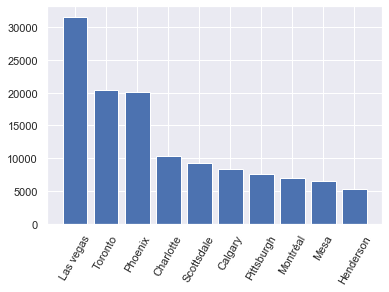

In [10]:
plt.bar(df_business['city'].value_counts().sort_values(ascending=False).index[:10], df_business['city'].value_counts().sort_values(ascending=False).values[:10])
plt.xticks(rotation=60)
plt.show()

* <font color='blue'> Toronto is chosen for further analysis:

In [11]:
df_business_toronto = df_business[df_business['city']=='Toronto']

In [12]:
df_business_toronto_rest = df_business_toronto[df_business_toronto['categories'].str.contains('Restaurants')]

### <font color='red'> 1. Map of Toronto Restaurants:

In [13]:
import folium
from folium import plugins
from IPython.display import display, HTML

In [14]:
lat_toronto = np.median(df_business_toronto_rest['latitude'])
lon_toronto = np.median(df_business_toronto_rest['longitude'])
map_toronto = folium.Map([lat_toronto, lon_toronto], zoom_start=20)  

* <font color='blue'> Heatmap to show density of restaurants distribution

In [29]:
import webbrowser

In [31]:
heat = plugins.HeatMap(list(df_business_toronto_rest[['latitude', 'longitude']].values), radius=20)
heatmap_toronto = map_toronto.add_child(heat)

heatmap_toronto.save('heatmap_toronto.html')
webbrowser.open('file://' + os.getcwd() + 'heatmap_toronto.html')

True

* <font color='blue'> Map of open restaurants and closed restaurants

In [32]:
df_business_toronto_rest_open = df_business_toronto_rest[df_business_toronto_rest['is_open']==1]

In [33]:
df_business_toronto_rest_closed = df_business_toronto_rest[df_business_toronto_rest['is_open']==0]

In [34]:
map_toronto_open_closed = folium.Map([lat_toronto, lon_toronto], zoom_start=20) 

for index, row in df_business_toronto_rest_open.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']], 
                        radius=4,
                        color="red", fill_color="red", 
                        ).add_to(map_toronto_open_closed)

for index, row in df_business_toronto_rest_closed.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']], 
                        radius=4,
                        color="blue"
                        ).add_to(map_toronto_open_closed)

In [35]:
map_toronto_open_closed.save('map_toronto_open_closed.html')
webbrowser.open('file://' + os.getcwd() + 'map_toronto_open_closed.html')

True

* <font color='blue'> Map of successful restaurants

> Calculate success score according to stars and review counts

In [38]:
def normalize(normalized_bounds, actual_bounds, data):
    return ([normalized_bounds[0] + (x - actual_bounds[0]) * (normalized_bounds[1] - normalized_bounds[0]) / (actual_bounds[1] - actual_bounds[0]) for x in data])

In [39]:
normalized_bounds = [df_business_toronto_rest.stars.min(), df_business_toronto_rest.stars.max()]
actual_bounds = [df_business_toronto_rest.review_count.min(), df_business_toronto_rest.review_count.max()]

In [40]:
df_business_toronto_rest['success_score'] = (normalize(normalized_bounds, actual_bounds, df_business_toronto_rest.review_count) + \
                                             df_business_toronto_rest.stars) / 2

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


> Plot the top 100 restaurants on map

In [41]:
df_business_toronto_success = df_business_toronto_rest.sort_values(by='success_score', ascending=False)

In [42]:
map_toronto_success = folium.Map([lat_toronto, lon_toronto], zoom_start=20) 

for index, row in df_business_toronto_success[:100].iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']], 
                        radius=10,
                        color="red", fill_color="red", 
                        ).add_to(map_toronto_success)

In [43]:
map_toronto_success.save('map_toronto_success.html')
webbrowser.open('file://' + os.getcwd() + 'map_toronto_success.html')

True